# **1️. Import Libraries & Setup**

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

# Check GPU
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# **2. Dataset Paths & Class Names**

In [31]:
# Set up paths
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

# Verify directories exist
print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))
print("Valid dir exists:", os.path.exists(valid_dir))

# Get class names from folder structure
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

# Number of classes
num_classes = len(class_names)
print("Number of classes:", num_classes)

Train dir exists: True
Test dir exists: True
Valid dir exists: True
Class names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Number of classes: 6


**->Load class names from training folder. Needed for model output and evaluation.**

# **3️. Data Generators**

In [32]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(valid_dir, target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE, class_mode='categorical',
                                                  shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


# **4️. Build CNN Model**

In [33]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,349,382 (70.00 MB)

 Trainable params: 18,349,382 (70.00 MB)

 Non-trainable params: 0 (0.00 B)

# **5️. Compile Model**

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# **6️. Training Callbacks**

In [35]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# **7️. Train the Model**

In [36]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 600ms/step - Precision: 0.3837 - Recall: 0.0178 - accuracy: 0.2245 - loss: 1.7493 - val_Precision: 0.5000 - val_Recall: 0.1667 - val_accuracy: 0.4167 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 545ms/step - Precision: 0.6334 - Recall: 0.3306 - accuracy: 0.5115 - loss: 1.1831 - val_Precision: 0.7188 - val_Recall: 0.6389 - val_accuracy: 0.7222 - val_loss: 1.1349 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 547ms/step - Precision: 0.8270 - Recall: 0.7531 - accuracy: 0.7952 - loss: 0.5710 - val_Precision: 0.9028 - val_Recall: 0.9028 - val_accuracy: 0.9028 - val_loss: 0.2381 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 519ms/step - Precision: 0.8671 - Recall: 0.8004 - accuracy: 0.8413 - loss: 0.4666 - val_Precision: 0.9014 - val_Recall: 0.8889 - val_accuracy: 0.9028 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 27s 518ms/step - Preci

# **8️. Evaluate & Confusion Matrix**

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


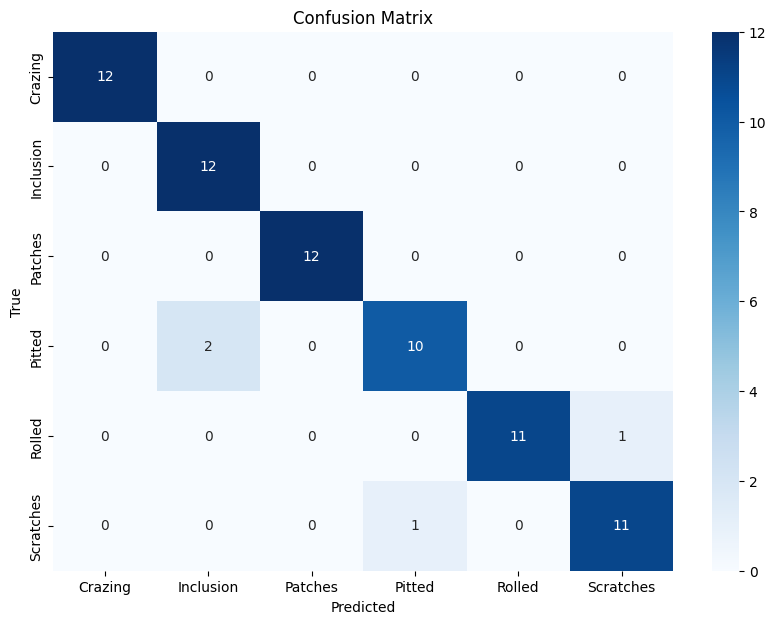

In [37]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **9️. Training Visualization**

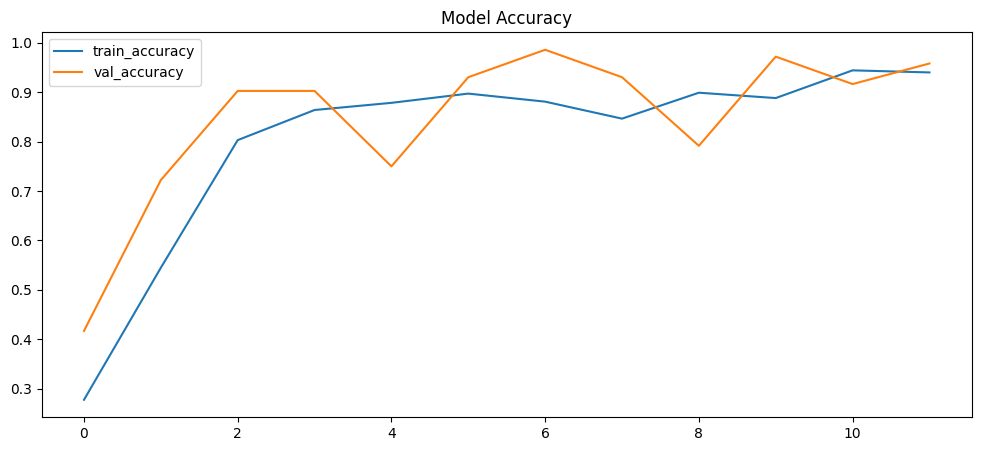

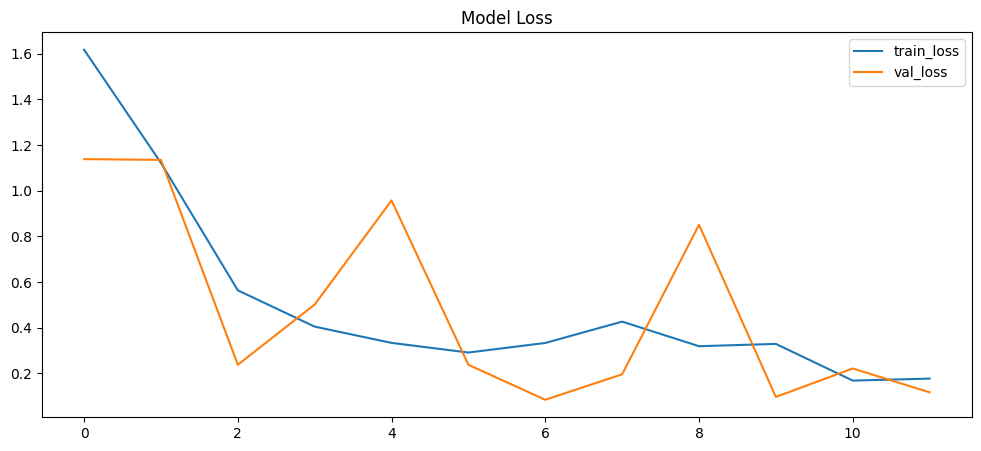

In [38]:
# Accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# **10️. Save Final Model**

In [39]:
model.save('final_steel_defect_model.keras')

In [40]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /kaggle/working


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


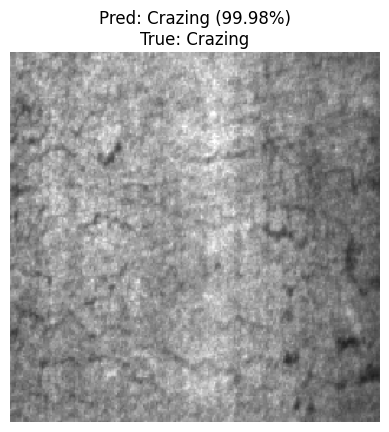

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


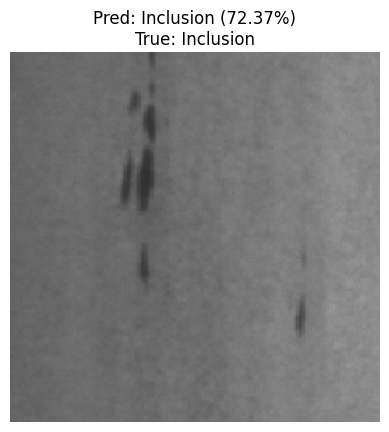

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


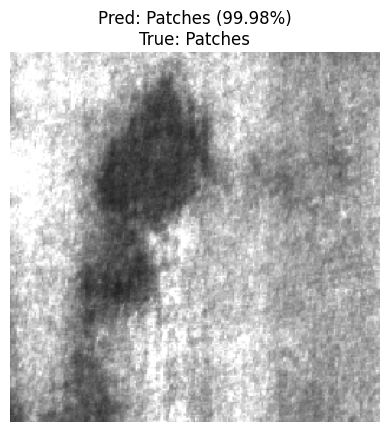

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


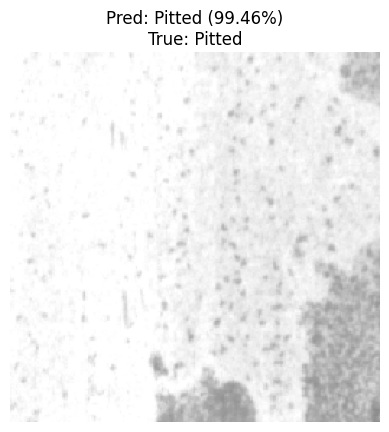

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


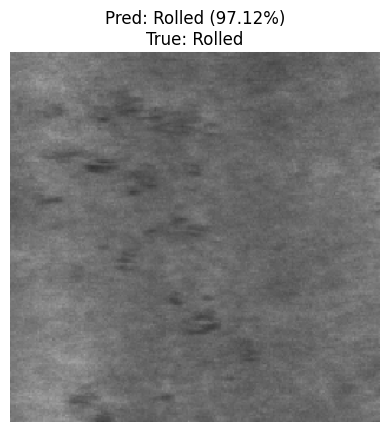

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


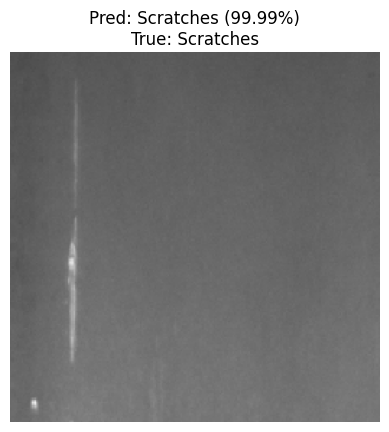

In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the trained model
model = load_model('final_steel_defect_model.keras')

# Function to predict single image and show predicted + true label
def predict_image(image_path, model, class_names, target_size=(256,256)):
    # Load image
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)
    
    # True class from folder name
    true_class = os.path.basename(os.path.dirname(image_path))
    
    # Plot
    plt.imshow(img)
    plt.title(f"Pred: {pred_class} ({confidence*100:.2f}%)\nTrue: {true_class}")
    plt.axis('off')
    plt.show()

# Example usage
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Crazing/Cr_103.bmp', model, class_names)
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion/In_10.bmp', model, class_names)
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Patches/Pa_1.bmp', model, class_names)
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Pitted/PS_101.bmp', model, class_names)
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Rolled/RS_100.bmp', model, class_names)
predict_image('/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Scratches/Sc_1.bmp', model, class_names)

In [5]:
# Function to load images and labels from directory with debugging
def load_data_from_directory(directory, target_size=(256, 256)):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_names = [name for name in class_names if os.path.isdir(os.path.join(directory, name))]
    
    print(f"\nProcessing directory: {directory}")
    print(f"Found classes: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        print(f"  Class: {class_name}")
        files_found = 0
        
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Added .bmp and case-insensitive check
                img_path = os.path.join(class_dir, filename)
                try:
                    # Load and preprocess image
                    img = load_img(img_path, target_size=target_size)
                    img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
                    images.append(img_array)
                    # Create one-hot encoded label
                    label = tf.keras.utils.to_categorical(class_idx, num_classes=len(class_names))
                    labels.append(label)
                    files_found += 1
                except Exception as e:
                    print(f"Error loading {img_path}: {str(e)}")
            else:
                print(f"Skipping {filename} - not a recognized image format")
        
        print(f"Found {files_found} images in {class_name}")
    
    if not images:
        print(f"WARNING: No images loaded from {directory}")
    
    return np.array(images), np.array(labels), class_names

# Load the datasets
x_train, y_train, class_names = load_data_from_directory(train_dir)
x_val, y_val, _ = load_data_from_directory(valid_dir)
x_test, y_test, _ = load_data_from_directory(test_dir)

# Print shapes and diagnostics
print("\nx_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("Class names:", class_names)


Processing directory: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train
Found classes: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
  Class: Crazing
Found 276 images in Crazing
  Class: Inclusion
Found 276 images in Inclusion
  Class: Patches
Found 276 images in Patches
  Class: Pitted
Found 276 images in Pitted
  Class: Rolled
Found 276 images in Rolled
  Class: Scratches
Found 276 images in Scratches

Processing directory: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid
Found classes: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
  Class: Crazing
Found 12 images in Crazing
  Class: Inclusion
Found 12 images in Inclusion
  Class: Patches
Found 12 images in Patches
  Class: Pitted
Found 12 images in Pitted
  Class: Rolled
Found 12 images in Rolled
  Class: Scratches
Found 12 images in Scratches

Processing directory: /kaggle/input/neu-metal-surface-defects-data/NEU Metal Su

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-10-14 15:38:05.873624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760456286.275111      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760456286.403953      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [7]:
import os

# Define dataset directories
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

# Verify directories
print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))
print("Valid dir exists:", os.path.exists(valid_dir))

# ✅ Get class names from subfolders in train directory
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

# ✅ Count number of classes
num_classes = len(class_names)
print("Number of classes:", num_classes)

Train dir exists: True
Test dir exists: True
Valid dir exists: True
Class names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Number of classes: 6


In [8]:
# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,349,382 (70.00 MB)

 Trainable params: 18,349,382 (70.00 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile with optimized Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load validation data from directory
val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [22]:
# Test data generator (no augmentation, only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,               # path to your test folder
    target_size=IMG_SIZE,   # same as train/val
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False            # important for evaluation
)

Found 72 images belonging to 6 classes.


In [14]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1760456486.784348     102 service.cc:148] XLA service 0x77fe000076c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760456486.786091     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760456486.786120     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760456487.354967     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - Precision: 0.1290 - Recall: 0.0625 - accuracy: 0.1094 - loss: 2.3176          

I0000 00:00:1760456496.564020     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 58s 847ms/step - Precision: 0.2918 - Recall: 0.0200 - accuracy: 0.2047 - loss: 1.8864 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3194 - val_loss: 1.4819 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 543ms/step - Precision: 0.5851 - Recall: 0.1064 - accuracy: 0.4647 - loss: 1.4089 - val_Precision: 0.6571 - val_Recall: 0.3194 - val_accuracy: 0.4861 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - Precision: 0.8477 - Recall: 0.5359 - accuracy: 0.7025 - loss: 0.8796 - val_Precision: 0.6769 - val_Recall: 0.6111 - val_accuracy: 0.6111 - val_loss: 0.9051 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 537ms/step - Precision: 0.8207 - Recall: 0.6174 - accuracy: 0.7333 - loss: 0.7752 - val_Precision: 0.9310 - val_Recall: 0.7500 - val_accuracy: 0.8056 - val_loss: 0.6231 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 546ms/step - Precisio

In [15]:
# Save the final model
model.save('final_model.keras')

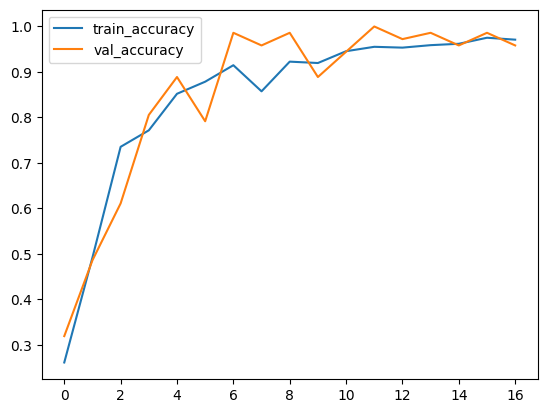

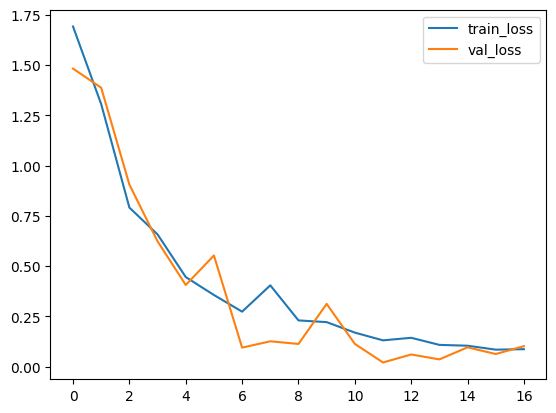

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 


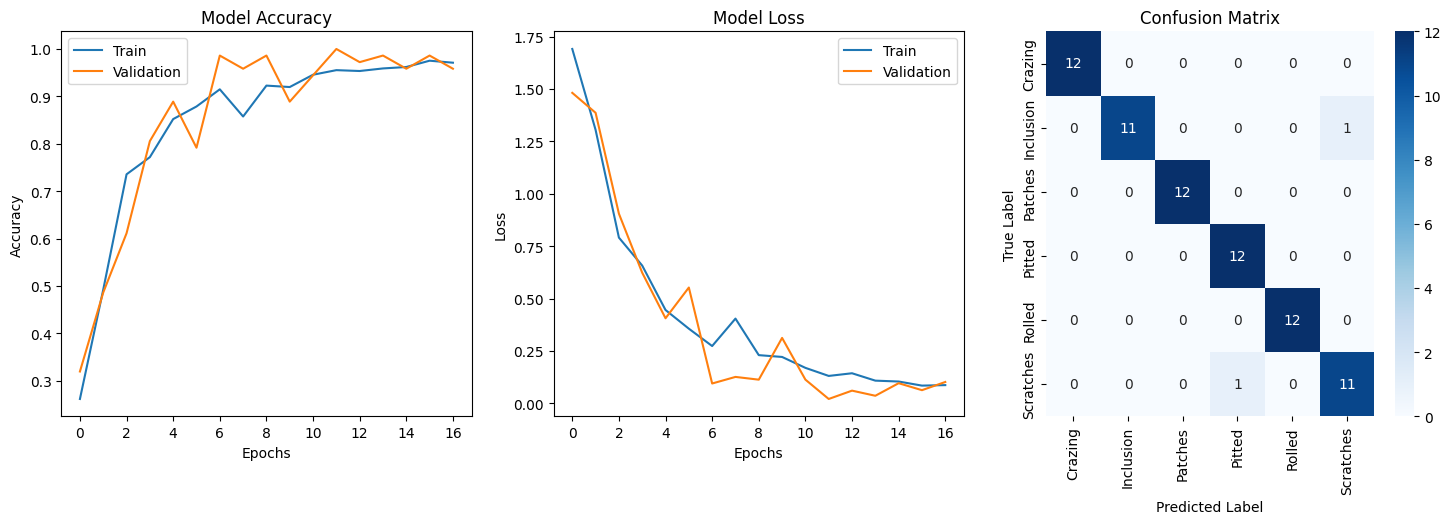

In [25]:
# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# True labels
y_true = test_generator.classes  # Already integer indices

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history, y_true, y_pred, class_names):
    plt.figure(figsize=(18, 5))
    
    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.show()

# Call the function
plot_training_history(history, y_true, y_pred, class_names)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


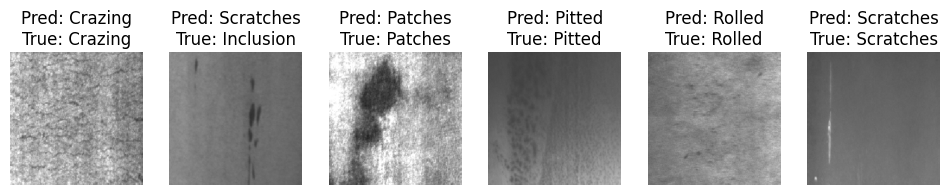

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions_generator(model, test_generator, class_names):
    # Predict on all test images
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    unique_classes = set()
    selected_indices = []

    # Find one example per class
    for i, label in enumerate(y_true):
        if label not in unique_classes:
            unique_classes.add(label)
            selected_indices.append(i)
        if len(unique_classes) == len(class_names):
            break

    # Plot predictions for selected indices
    plt.figure(figsize=(len(class_names) * 2, 3))
    for idx, sample_idx in enumerate(selected_indices):
        plt.subplot(1, len(class_names), idx + 1)
        # test_generator[index][0] gives batch of images
        # compute batch index and image index within batch
        batch_size = test_generator.batch_size
        batch_idx = sample_idx // batch_size
        img_idx = sample_idx % batch_size
        img = test_generator[batch_idx][0][img_idx]

        plt.imshow(img)
        pred_class = class_names[y_pred[sample_idx]]
        true_class = class_names[y_true[sample_idx]]
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')

    plt.show()

# Call the function
visualize_predictions_generator(model, test_generator, class_names)